In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate, remove_bad_data, chi2_analysis
import pandas as pd
import numpy as np
# from tqdm import tqdm

from scipy import stats
print(pp.__version__)

import matplotlib.pyplot as plt
import ruptures as rpt

from tqdm import tqdm
from numpy import diff
# from julia.PowerModels import run_ac_opf
# from julia.PowerModels import run_ac_opf

2.0.1


In [2]:
def create_measurement_unit(df_measurement, net):
    list_value=[]
    list_std=[]
    for index, row in df_measurement.iterrows():
        if row['element_type'] =='bus':
            if row['meas_type'] =='v':
                mu= net.res_bus.iloc[row['element'],0]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='p':
                mu= net.res_bus.iloc[row['element'],2]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='q':
                mu= net.res_bus.iloc[row['element'],3]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
                
        elif row['element_type'] =='line':
            if row['side']=='from':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                    
                    
        elif row['element_type'] =='trafo':
            if row['side']=='from':
                if row['meas_type'] == 'i':
                    mu =net.res_trafo.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'p':
                    mu =net.res_trafo.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'q':
                    mu =net.res_trafo.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='i':
                    mu =net.res_trafo.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='p':
                    mu =net.res_trafo.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='q':
                    mu =net.res_trafo.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
#         print(mu)  
        value = np.random.normal(mu, sigma, 1)
        list_value.append(value[0])
        list_std.append(sigma)
    df_measurement['value']=list_value
    df_measurement['std_dev']=list_std

    for index, row in df_measurement.iterrows():
        if row['element_type']=='bus':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'])
        elif row['element_type']=='line':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'], side=row['side'])
        elif row['element_type']=='trafo':
            if row['meas_type'] in ['p','q']:
                pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                      std_dev=row['std_dev'], element=row['element'], side=row['side'])
    return df_measurement, net

# simple four bus system

In [358]:
#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.8,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0,0])
# scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar=np.array([np.random.normal(item, 0.05, 1)[0] if item !=0 else np.zeros(1)[0] for ind in range(len(scaling_for_solar)-1) for item in np.linspace(scaling_for_solar[ind], scaling_for_solar[ind+1],60)])
scaling_for_solar=np.array([value if value >0 else np.zeros(1)[0] for value in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)

In [359]:
scaling_for_solar[0][800:805]=0.1
scaling_for_solar[0][705:710]=0.1
scaling_for_solar[0][677:682]=0.1

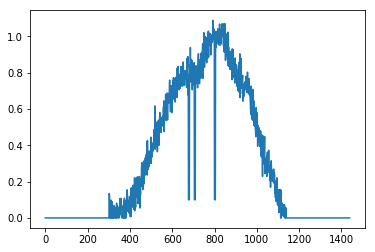

In [360]:
fig, ax = plt.subplots()

ax.plot(range(len(scaling_for_solar[0])), scaling_for_solar[0])
plt.show()

In [361]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.03
lower_bus_accuracy=0.97
upper_line_accuracy=1.05
lower_line_accuracy=0.95
upper_trafo_accuracy=1.05
lower_trafo_accuracy=0.95

In [396]:
p_mw=np.array([[0,0,0,0]])
pv_location=np.random.randint(2, size=2)
# pv_location=[0,0]
print(pv_location)
for scaling_solar, load_scaling in tqdm(zip(scaling_for_solar[0],scaling_for_load[0]), total=len(scaling_for_solar[0])):
    net = pn.simple_four_bus_system()
    net.sgen.scaling=[scaling_solar*pv_location[0], scaling_solar*pv_location[1]]
    net.sgen.q_mvar[:]=0
    net.sgen.p_mw=[0.03,0.05]
    net.load.scaling=[load_scaling, load_scaling]
    pp.runpp(net)
    df_measurement=pd.DataFrame()
    df_measurement['meas_type']=['v','v','p','p','q','q','i','i']
    df_measurement['element_type']=['bus','bus','line','line','line','line','line','line']
    df_measurement['element']=[2,3,0,1,0,1,0,1]
    df_measurement['side']=['None','None','from','from','from','from','from','from']
    df_measurement, net = create_measurement_unit(df_measurement, net)
    success = estimate(net, init="slack", calculate_voltage_angles=True, zero_injection=[1])
    new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
    p_mw=np.concatenate((p_mw, new_mw), axis=0)






  0%|          | 0/1440 [00:00<?, ?it/s]

[1 0]







  0%|          | 1/1440 [00:00<06:44,  3.56it/s]




  0%|          | 2/1440 [00:00<07:00,  3.42it/s]




  0%|          | 3/1440 [00:00<06:49,  3.51it/s]




  0%|          | 4/1440 [00:01<06:42,  3.57it/s]




  0%|          | 5/1440 [00:01<06:46,  3.53it/s]




  0%|          | 6/1440 [00:01<06:49,  3.50it/s]




  0%|          | 7/1440 [00:01<06:41,  3.57it/s]




  1%|          | 8/1440 [00:02<06:28,  3.68it/s]




  1%|          | 9/1440 [00:02<06:32,  3.64it/s]




  1%|          | 10/1440 [00:02<06:26,  3.70it/s]




  1%|          | 11/1440 [00:03<06:48,  3.50it/s]




  1%|          | 12/1440 [00:03<07:28,  3.18it/s]




  1%|          | 13/1440 [00:03<07:27,  3.19it/s]




  1%|          | 14/1440 [00:04<07:09,  3.32it/s]




  1%|          | 15/1440 [00:04<06:49,  3.48it/s]




  1%|          | 16/1440 [00:04<06:44,  3.52it/s]




  1%|          | 17/1440 [00:04<06:57,  3.41it/s]




  1%|▏         | 18/1440 [00:05<06:40,  3.55it/s]




  1%|▏         | 19/1440 [00:05<

 16%|█▋        | 236/1440 [01:00<05:03,  3.97it/s]




 16%|█▋        | 237/1440 [01:01<05:04,  3.95it/s]




 17%|█▋        | 238/1440 [01:01<05:03,  3.97it/s]




 17%|█▋        | 239/1440 [01:01<05:02,  3.97it/s]




 17%|█▋        | 240/1440 [01:01<05:01,  3.98it/s]




 17%|█▋        | 241/1440 [01:02<05:03,  3.95it/s]




 17%|█▋        | 242/1440 [01:02<05:02,  3.96it/s]




 17%|█▋        | 243/1440 [01:02<05:02,  3.96it/s]




 17%|█▋        | 244/1440 [01:02<05:01,  3.97it/s]




 17%|█▋        | 245/1440 [01:03<05:06,  3.90it/s]




 17%|█▋        | 246/1440 [01:03<05:05,  3.91it/s]




 17%|█▋        | 247/1440 [01:03<05:03,  3.93it/s]




 17%|█▋        | 248/1440 [01:03<05:02,  3.95it/s]




 17%|█▋        | 249/1440 [01:04<05:01,  3.95it/s]




 17%|█▋        | 250/1440 [01:04<05:00,  3.96it/s]




 17%|█▋        | 251/1440 [01:04<05:00,  3.96it/s]




 18%|█▊        | 252/1440 [01:04<04:59,  3.96it/s]




 18%|█▊        | 253/1440 [01:05<04:59,  3.96it/s]




 18%|█▊   

 33%|███▎      | 470/1440 [02:00<04:03,  3.98it/s]




 33%|███▎      | 471/1440 [02:01<04:02,  3.99it/s]




 33%|███▎      | 472/1440 [02:01<04:01,  4.00it/s]




 33%|███▎      | 473/1440 [02:01<04:00,  4.02it/s]




 33%|███▎      | 474/1440 [02:01<04:21,  3.70it/s]




 33%|███▎      | 475/1440 [02:02<04:30,  3.57it/s]




 33%|███▎      | 476/1440 [02:02<04:34,  3.51it/s]




 33%|███▎      | 477/1440 [02:02<04:48,  3.33it/s]




 33%|███▎      | 478/1440 [02:03<04:36,  3.48it/s]




 33%|███▎      | 479/1440 [02:03<04:27,  3.59it/s]




 33%|███▎      | 480/1440 [02:03<04:37,  3.46it/s]




 33%|███▎      | 481/1440 [02:03<04:27,  3.59it/s]




 33%|███▎      | 482/1440 [02:04<04:38,  3.44it/s]




 34%|███▎      | 483/1440 [02:04<04:39,  3.43it/s]




 34%|███▎      | 484/1440 [02:04<04:32,  3.51it/s]




 34%|███▎      | 485/1440 [02:05<04:39,  3.42it/s]




 34%|███▍      | 486/1440 [02:05<04:31,  3.52it/s]




 34%|███▍      | 487/1440 [02:05<04:29,  3.53it/s]




 34%|███▍ 

 49%|████▉     | 704/1440 [03:01<03:30,  3.49it/s]




 49%|████▉     | 705/1440 [03:02<03:48,  3.22it/s]




 49%|████▉     | 706/1440 [03:02<03:43,  3.28it/s]




 49%|████▉     | 707/1440 [03:02<03:50,  3.18it/s]




 49%|████▉     | 708/1440 [03:03<03:48,  3.21it/s]




 49%|████▉     | 709/1440 [03:03<03:46,  3.22it/s]




 49%|████▉     | 710/1440 [03:03<03:44,  3.25it/s]




 49%|████▉     | 711/1440 [03:04<03:46,  3.22it/s]




 49%|████▉     | 712/1440 [03:04<03:42,  3.27it/s]




 50%|████▉     | 713/1440 [03:04<03:38,  3.33it/s]




 50%|████▉     | 714/1440 [03:04<03:29,  3.47it/s]




 50%|████▉     | 715/1440 [03:05<03:27,  3.49it/s]




 50%|████▉     | 716/1440 [03:05<03:31,  3.43it/s]




 50%|████▉     | 717/1440 [03:05<03:32,  3.40it/s]




 50%|████▉     | 718/1440 [03:06<03:44,  3.22it/s]




 50%|████▉     | 719/1440 [03:06<03:48,  3.16it/s]




 50%|█████     | 720/1440 [03:06<03:41,  3.26it/s]




 50%|█████     | 721/1440 [03:07<03:45,  3.18it/s]




 50%|█████

 65%|██████▌   | 938/1440 [04:03<02:06,  3.97it/s]




 65%|██████▌   | 939/1440 [04:03<02:06,  3.98it/s]




 65%|██████▌   | 940/1440 [04:04<02:05,  3.99it/s]




 65%|██████▌   | 941/1440 [04:04<02:04,  4.00it/s]




 65%|██████▌   | 942/1440 [04:04<02:04,  4.01it/s]




 65%|██████▌   | 943/1440 [04:04<02:03,  4.02it/s]




 66%|██████▌   | 944/1440 [04:05<02:03,  4.03it/s]




 66%|██████▌   | 945/1440 [04:05<02:09,  3.83it/s]




 66%|██████▌   | 946/1440 [04:05<02:07,  3.89it/s]




 66%|██████▌   | 947/1440 [04:05<02:05,  3.94it/s]




 66%|██████▌   | 948/1440 [04:06<02:04,  3.96it/s]




 66%|██████▌   | 949/1440 [04:06<02:03,  3.98it/s]




 66%|██████▌   | 950/1440 [04:06<02:02,  4.00it/s]




 66%|██████▌   | 951/1440 [04:06<02:01,  4.01it/s]




 66%|██████▌   | 952/1440 [04:07<02:02,  3.99it/s]




 66%|██████▌   | 953/1440 [04:07<02:01,  4.01it/s]




 66%|██████▋   | 954/1440 [04:07<02:01,  4.01it/s]




 66%|██████▋   | 955/1440 [04:07<02:00,  4.01it/s]




 66%|█████

 81%|████████  | 1169/1440 [05:02<01:07,  4.00it/s]




 81%|████████▏ | 1170/1440 [05:02<01:07,  3.99it/s]




 81%|████████▏ | 1171/1440 [05:03<01:07,  3.99it/s]




 81%|████████▏ | 1172/1440 [05:03<01:06,  4.01it/s]




 81%|████████▏ | 1173/1440 [05:03<01:06,  4.01it/s]




 82%|████████▏ | 1174/1440 [05:03<01:06,  4.02it/s]




 82%|████████▏ | 1175/1440 [05:04<01:05,  4.02it/s]




 82%|████████▏ | 1176/1440 [05:04<01:05,  4.03it/s]




 82%|████████▏ | 1177/1440 [05:04<01:05,  4.02it/s]




 82%|████████▏ | 1178/1440 [05:04<01:05,  4.03it/s]




 82%|████████▏ | 1179/1440 [05:05<01:04,  4.04it/s]




 82%|████████▏ | 1180/1440 [05:05<01:04,  4.03it/s]




 82%|████████▏ | 1181/1440 [05:05<01:04,  4.03it/s]




 82%|████████▏ | 1182/1440 [05:05<01:03,  4.03it/s]




 82%|████████▏ | 1183/1440 [05:06<01:03,  4.03it/s]




 82%|████████▏ | 1184/1440 [05:06<01:03,  4.03it/s]




 82%|████████▏ | 1185/1440 [05:06<01:03,  4.03it/s]




 82%|████████▏ | 1186/1440 [05:06<01:03,  4.02it

 97%|█████████▋| 1399/1440 [06:01<00:10,  3.91it/s]




 97%|█████████▋| 1400/1440 [06:01<00:10,  3.91it/s]




 97%|█████████▋| 1401/1440 [06:02<00:09,  3.91it/s]




 97%|█████████▋| 1402/1440 [06:02<00:09,  3.92it/s]




 97%|█████████▋| 1403/1440 [06:02<00:09,  3.93it/s]




 98%|█████████▊| 1404/1440 [06:02<00:09,  3.90it/s]




 98%|█████████▊| 1405/1440 [06:03<00:08,  3.91it/s]




 98%|█████████▊| 1406/1440 [06:03<00:08,  3.93it/s]




 98%|█████████▊| 1407/1440 [06:03<00:08,  3.94it/s]




 98%|█████████▊| 1408/1440 [06:03<00:08,  3.94it/s]




 98%|█████████▊| 1409/1440 [06:04<00:07,  3.94it/s]




 98%|█████████▊| 1410/1440 [06:04<00:07,  3.94it/s]




 98%|█████████▊| 1411/1440 [06:04<00:07,  3.94it/s]




 98%|█████████▊| 1412/1440 [06:04<00:07,  3.95it/s]




 98%|█████████▊| 1413/1440 [06:05<00:06,  3.96it/s]




 98%|█████████▊| 1414/1440 [06:05<00:06,  3.96it/s]




 98%|█████████▊| 1415/1440 [06:05<00:06,  3.96it/s]




 98%|█████████▊| 1416/1440 [06:05<00:06,  3.96it

In [397]:
df=pd.DataFrame()
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
bus_has_solar_PV=[]
for bus in range(0,len(p_mw[0])):
    df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
    print('correlation at bus {} is: {}'.format(bus, corr))
    if corr <-0.2:
        bus_has_solar_PV.append(bus)

correlation at bus 0 is: 0.7169878014166676
correlation at bus 1 is: 0.004848775366142512
correlation at bus 2 is: -0.9083153366420258
correlation at bus 3 is: 0.009251200688355056


In [398]:
bus_has_solar_PV

[2]

In [399]:
# bus_has_solar_PV=[2,3]



#combine solar scaling and p_mw at solar located bus
new_p_mw=p_mw.copy()
new_p_mw=new_p_mw.transpose()
# new_p_mw[2].shape=(1441,1)
my_array=np.array([scaling_for_solar[0]]).T.copy()
for located_bus in bus_has_solar_PV:
    my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

In [400]:
algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
my_bkps = algo.predict(pen=1)

In [401]:
my_bkps

[302,
 406,
 454,
 498,
 523,
 558,
 579,
 623,
 677,
 682,
 705,
 710,
 754,
 800,
 805,
 864,
 905,
 969,
 989,
 1015,
 1038,
 1085,
 1115,
 1440]

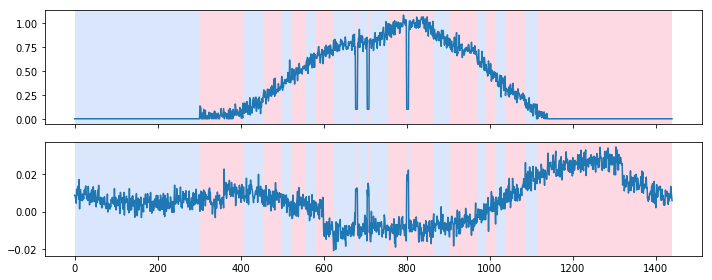

In [402]:
# display
rpt.display(my_array, my_bkps)
plt.show()

In [403]:
for bus in bus_has_solar_PV:
    sum_value=np.array([])
    for period in my_bkps[:-1]:
    #     print(period)
        value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
        if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
    #         print(value)
            sum_value = np.append(sum_value, value)
    print('bus :', bus, 'has solar PV size: ', sum_value.sum()/len(sum_value)) 

bus : 2 has solar PV size:  -0.030185765723053263


In [340]:
sum_value.sum()/len(sum_value)

-0.010217949356656396

In [389]:
net.sgen.p_mw=[30,10]



In [392]:
print(net.sgen)

  name  bus  p_mw  q_mvar  sn_mva  scaling  in_service  type  current_source
0  pv1    2    30     0.0    0.03      0.0        True  None            True
1  pv2    3    10     0.0    0.02      0.0        True  None            True


# CIGRE Task Force C6.04.02 

In [3]:
#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.8,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0,0])
# scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar=np.array([np.random.normal(item, 0.05, 1)[0] if item !=0 else np.zeros(1)[0] for ind in range(len(scaling_for_solar)-1) for item in np.linspace(scaling_for_solar[ind], scaling_for_solar[ind+1],60)])
scaling_for_solar=np.array([value if value >0 else np.zeros(1)[0] for value in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)

In [5]:
scaling_for_solar[0][800:805]=0.1
scaling_for_solar[0][705:710]=0.1
scaling_for_solar[0][677:682]=0.1

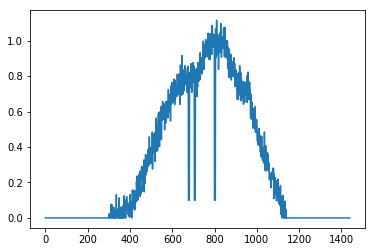

In [6]:
fig, ax = plt.subplots()

ax.plot(range(len(scaling_for_solar[0])), scaling_for_solar[0])
plt.show()

In [7]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.03
lower_bus_accuracy=0.97
upper_line_accuracy=1.05
lower_line_accuracy=0.95
upper_trafo_accuracy=1.03
lower_trafo_accuracy=0.97

In [48]:
list_bus_meas=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
list_line_meas=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
list_transfo_meas=[0,1]
df_measurement=pd.DataFrame()
df_measurement['meas_type']=['v']*len(list_bus_meas)+['p','q','i']*len(list_line_meas)+['p','q','i']*len(list_transfo_meas)
df_measurement['element_type']=['bus']*len(list_bus_meas)+['line','line','line']*len(list_line_meas)+['trafo','trafo','trafo']*len(list_transfo_meas)
df_measurement['element']=[item for item in list_bus_meas]+[item for item in list_line_meas for x in range(3)]+[item for item in list_transfo_meas for x in range(3)]
df_measurement['side']=['None']*len(list_bus_meas)+['from','from','from']*len(list_line_meas)+['to','to','to']*len(list_transfo_meas)
p_mw=np.array([np.zeros(15)])


net = pn.create_cigre_network_mv(with_der="pv_wind")
zero_inject_bus= list(set(net.bus.index).difference(set(np.where(net.gen.p_mw!=0)[0]).union(set(net.load.bus)).union(net.ext_grid.bus).union(net.shunt.bus)))
net.load.drop([0,8], axis=0, inplace=True)
net.load.reset_index(drop=True, inplace=True)
net.sgen.drop([8], axis=0, inplace=True)
net.sgen.reset_index(drop=True, inplace=True)
net.switch.closed=[True]*2+[True]*2+[True]*2+[True]*2
pv_location=np.random.randint(2, size=8)

print(pv_location)
for scaling_solar, load_scaling in tqdm(zip(scaling_for_solar[0],scaling_for_load[0]), total=len(scaling_for_solar[0])):
    net.sgen.scaling=scaling_solar*pv_location
    net.load.scaling[:]=load_scaling
    pp.runpp(net)
    df_measurement, net = create_measurement_unit(df_measurement, net)
    success = estimate(net, init="flat", zero_injection=zero_inject_bus)
#     print(net.res_bus-net.res_bus_est)
    new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
    p_mw=np.concatenate((p_mw, new_mw), axis=0)

  0%|          | 0/1440 [00:00<?, ?it/s]

[0 0 1 1 0 1 1 1]


100%|██████████| 1440/1440 [12:04<00:00,  1.98it/s]


In [55]:
df=pd.DataFrame()
# df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
bus_has_solar_PV=[]
for bus in range(0,len(p_mw[0])):
#     df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
    print('correlation at bus {} is: {}'.format(bus, corr))
    if corr < 0:
        bus_has_solar_PV.append(bus)

correlation at bus 0 is: -0.004135296703287942
correlation at bus 1 is: 0.004648728059521336
correlation at bus 2 is: -0.027772259911825314
correlation at bus 3 is: 0.016315762667992187
correlation at bus 4 is: 0.0040634789083038615
correlation at bus 5 is: -0.08321757528398939
correlation at bus 6 is: -0.10847177892705201
correlation at bus 7 is: -0.03492521139411798
correlation at bus 8 is: 0.0073828610346895465
correlation at bus 9 is: -0.12461124265223011
correlation at bus 10 is: -0.1526252808515308
correlation at bus 11 is: -0.06145602150024871
correlation at bus 12 is: 0.004699345695239713
correlation at bus 13 is: 0.06472357196534904
correlation at bus 14 is: -0.009768493025826835


In [58]:
bus_has_solar_PV=[item for item in bus_has_solar_PV if item not in [0,2,13,14]]

In [59]:
bus_has_solar_PV

[5, 6, 7, 9, 10, 11]

In [60]:
pv_location

array([0, 0, 1, 1, 0, 1, 1, 1])

In [61]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,PV 3,3,0.02,0.0,0.02,0.0,True,PV,True
1,PV 4,4,0.02,0.0,0.02,0.0,True,PV,True
2,PV 5,5,0.03,0.0,0.03,0.0,True,PV,True
3,PV 6,6,0.03,0.0,0.03,0.0,True,PV,True
4,PV 8,8,0.03,0.0,0.03,0.0,True,PV,True
5,PV 9,9,0.03,0.0,0.03,0.0,True,PV,True
6,PV 10,10,0.04,0.0,0.04,0.0,True,PV,True
7,PV 11,11,0.01,0.0,0.01,0.0,True,PV,True


In [62]:
#combine solar scaling and p_mw at solar located bus
new_p_mw=p_mw.copy()
new_p_mw=new_p_mw.transpose()
# new_p_mw[2].shape=(1441,1)
my_array=np.array([scaling_for_solar[0]]).T.copy()

#add solar PV detection at bus here!!
# bus_has_solar_PV=[]
for located_bus in bus_has_solar_PV:
    my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

In [63]:
my_array

array([[0.        , 0.30205368, 0.22517833, ..., 0.2536969 , 0.22321741,
        0.13793128],
       [0.        , 0.32698238, 0.25306764, ..., 0.26420117, 0.24086636,
        0.1513629 ],
       [0.        , 0.23379214, 0.18425784, ..., 0.20759951, 0.1833108 ,
        0.11230054],
       ...,
       [0.        , 0.14792031, 0.10998756, ..., 0.12724959, 0.10899054,
        0.06599022],
       [0.        , 0.11190932, 0.07940208, ..., 0.08772508, 0.08176089,
        0.05163476],
       [0.        , 0.13872536, 0.10097171, ..., 0.11544331, 0.10169322,
        0.06636294]])

In [64]:
algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
my_bkps = algo.predict(pen=1)

In [65]:
my_bkps

[59,
 297,
 360,
 431,
 480,
 524,
 550,
 600,
 659,
 677,
 682,
 705,
 710,
 747,
 784,
 800,
 805,
 867,
 906,
 970,
 1005,
 1060,
 1093,
 1141,
 1254,
 1320,
 1380,
 1440]

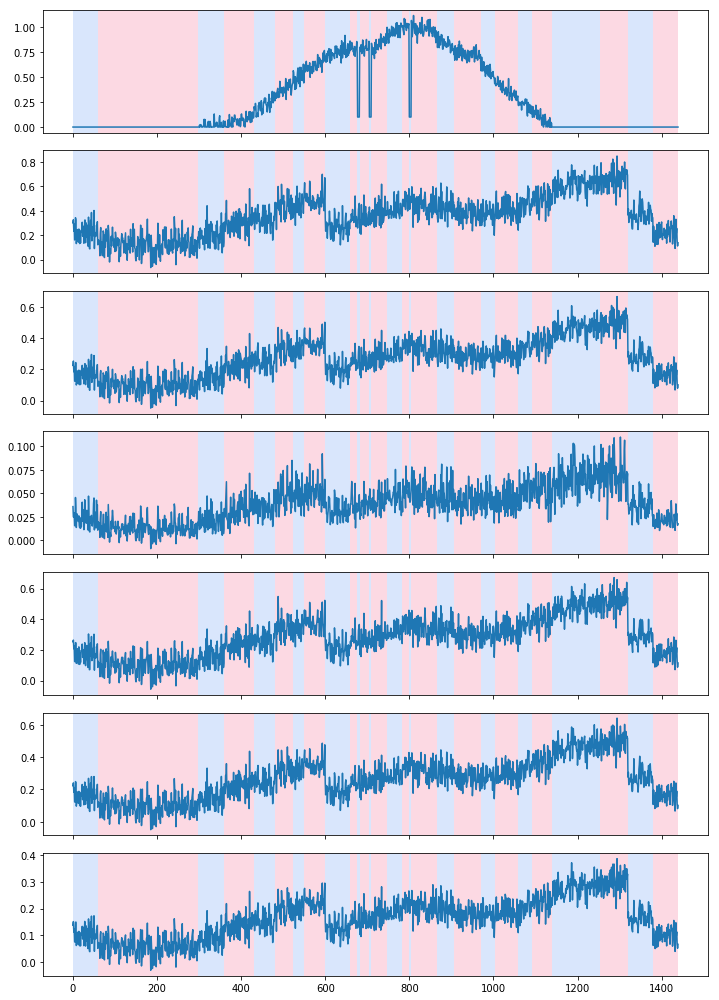

In [66]:
# display
rpt.display(my_array, my_bkps)
plt.show()

In [67]:
for bus in bus_has_solar_PV:
    sum_value=np.array([])
    for period in my_bkps[:-1]:
        value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
        if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
            sum_value = np.append(sum_value, value)
    print('bus :', bus, 'has solar PV size: ', sum_value.sum()/len(sum_value)) 

bus : 5 has solar PV size:  -0.5751130111253263
bus : 6 has solar PV size:  -0.5570852173041961
bus : 7 has solar PV size:  0.04061248262966703
bus : 9 has solar PV size:  -0.5345382448277122
bus : 10 has solar PV size:  -0.5207070297300648
bus : 11 has solar PV size:  -0.2833943113856301


In [ ]:
-0.8313807232780226*0.08163846840673522

In [ ]:
net.sgen

# Other buses

In [79]:
# list_networks=[pn.simple_four_bus_system(), pn.case5(), pn.case6ww(), pn.case9(), pn.case14(), 
#                 pn.case24_ieee_rts(), pn.case_ieee30(), pn.case39(), pn.case57()]

# list_networks=[pn.case118(), pn.case145(), pn.case_illinois200(), pn.case300()]


# list_networks=[pn.GBreducednetwork(), pn.iceland()]
# list_networks=[pn.create_cigre_network_hv(length_km_6a_6b=0.1)]
for ind, network in enumerate(list_networks):
    # net = pn.case14()
    net = network
    # net = pn.create_cigre_network_mv(with_der="pv_wind")
    zero_inject_bus= list(set(net.bus.index).difference(set(np.where(net.gen.p_mw!=0)[0]).union(set(net.load.bus)).union(net.ext_grid.bus).union(net.shunt.bus)))
    list_bus_meas=list(set(net.bus.index)-set(zero_inject_bus))
    list_line_meas=list(set(net.line.index))
    list_transfo_meas=list(set(net.trafo.index))

    df_measurement=pd.DataFrame()
    df_measurement['meas_type']=['v']*len(list_bus_meas)+['p','q','i']*len(list_line_meas)+['p','q','i']*len(list_transfo_meas)
    df_measurement['element_type']=['bus']*len(list_bus_meas)+['line','line','line']*len(list_line_meas)+['trafo','trafo','trafo']*len(list_transfo_meas)
    df_measurement['element']=[item for item in list_bus_meas]+[item for item in list_line_meas for x in range(3)]+[item for item in list_transfo_meas for x in range(3)]
    df_measurement['side']=['None']*len(list_bus_meas)+['from','from','from']*len(list_line_meas)+['to','to','to']*len(list_transfo_meas)

    p_mw=np.array([np.zeros(118)])
    # net.load.drop([0,8], axis=0, inplace=True)
    # net.load.reset_index(drop=True, inplace=True)
    # net.switch.closed=[True]*2+[True]*2+[True]*2+[True]*2
    pp.runpp(net)
    print('start create measurement')
    df_measurement, net = create_measurement_unit(df_measurement, net)
    print('done created measurement')
    success = estimate(net, init="flat", zero_injection=zero_inject_bus)
    print('network:', ind , 'result SE:', success)

start create measurement
done created measurement
network: 0 result SE: False
